### 1. Import Libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from google.colab import files

### 2. Preprocessing the Image

In [13]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    width, height = img.size
    new_width = width - (width % 8)
    new_height = height - (height % 8)
    img = img.crop((0, 0, new_width, new_height))  # Ensure dimensions divisible by 8
    img = img.resize((256, 256))  # Resize to 256x256
    return np.array(img)

### Explanation:

-	Ensures the image is grayscale.
-	Crops image so width & height are divisible by 8 for 8×8 blocks.
-	Resizes to 256×256 for consistency.
-	Returns a NumPy array for matrix operations.

## 3. Compress a Single 8×8 Block with Top-k Singular Values



In [14]:
def compress_block(block, k):
    U, S, V = np.linalg.svd(block)
    return U[:, :k] @ np.diag(S[:k]) @ V[:k, :]

#### Explaination:
- Applies SVD to the block.
- Keeps only the top-𝑘 singular values and vectors.
- 	Reconstructs a compressed version of the block.

## 4. Compress Entire Image Block-by-Block + Analyze


In [15]:
def compress_image(image, k_values):
    h, w = image.shape
    block_size = 8
    compressed_images = []
    compression_ratios = []
    reconstruction_errors = []

    for k in k_values:
        compressed_image = np.zeros_like(image, dtype=np.float64)

        for i in range(0, h, block_size):
            for j in range(0, w, block_size):
                block = image[i:i+block_size, j:j+block_size]
                compressed_block = compress_block(block, k)
                compressed_image[i:i+block_size, j:j+block_size] = compressed_block

        compressed_images.append(compressed_image)

        # Compression ratio: Original values (64) / Reduced values using k
        original_vals = block_size * block_size
        compressed_vals = k * (block_size + block_size + 1)
        compression_ratios.append(original_vals / compressed_vals)

        # Error (Frobenius norm)
        error = np.linalg.norm(image - compressed_image)
        reconstruction_errors.append(error)

    return compressed_images, compression_ratios, reconstruction_errors

### Explanation:
•	Iterates over each block (8×8) in the image.
•	Compresses and reconstructs each block.
•	Measures based on Compression ratio: based on how much data we retain and reconstruction error: using Frobenius norm.

##  5. Plot Compression Ratio and Reconstruction Error

In [16]:
def plot_results(k_values, compression_ratios, errors):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_values, compression_ratios, marker='o')
    plt.title('Compression Ratio vs k')
    plt.xlabel('k')
    plt.ylabel('Compression Ratio')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_values, errors, marker='o', color='orange')
    plt.title('Reconstruction Error vs k')
    plt.xlabel('k')
    plt.ylabel('Error (Frobenius norm)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Explanation:

- Left plot shows how compression improves as k increases.
- Right plot shows how error reduces with more singular values.


### 6. Display Original and Reconstructed Images Side-by-Side

In [17]:
def display_images(original, compressed_imgs, k_values_to_show):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, len(k_values_to_show) + 1, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    for idx, k in enumerate(k_values_to_show):
        plt.subplot(1, len(k_values_to_show) + 1, idx + 2)
        plt.imshow(compressed_imgs[k-1].astype(np.uint8), cmap='gray')
        plt.title(f'k = {k}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### Explanation:
- Shows the original and selected compressed images (k = 1, 3, 5, 8) in one row.
-	Helps visualize quality improvements.

### 7. Run the Whole Pipeline

Saving Golden_Retriever_puppies.jpeg to Golden_Retriever_puppies (3).jpeg


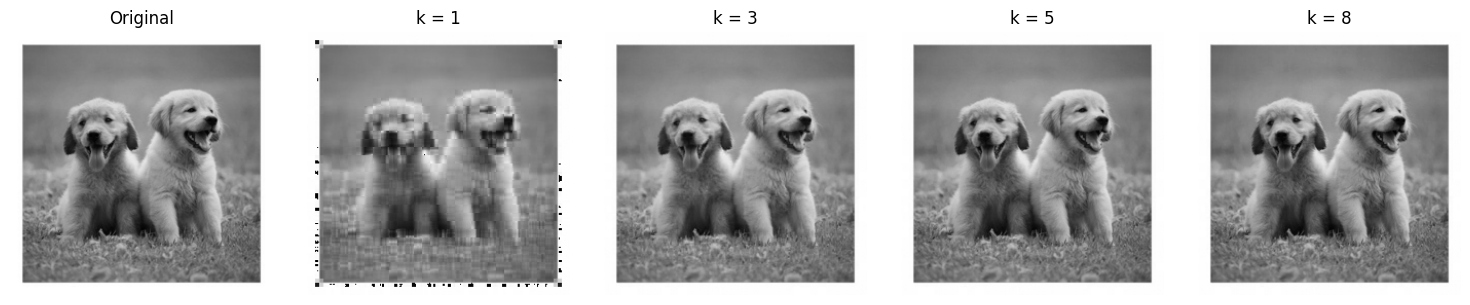

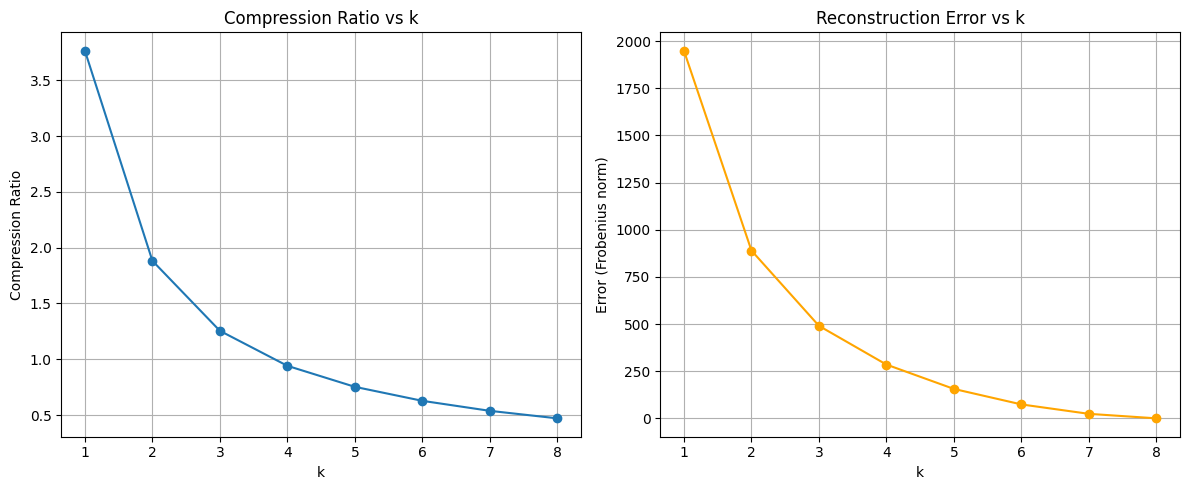

In [18]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = preprocess_image(image_path)

k_vals = list(range(1, 9))  # Blockwise k values
compressed_imgs, ratios, errors = compress_image(image, k_vals)

display_images(image, compressed_imgs, [1, 3, 5, 8])
plot_results(k_vals, ratios, errors)

### Explanation:
-	Uploads image using Colab UI.
-	Runs full pipeline: preprocessing → compression → visualization.
-	Shows both qualitative and quantitative insights.